<a href="https://colab.research.google.com/github/amber3536/Wildfire_Prediction/blob/main/Resunet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, concatenate

def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def get_model(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

from keras import backend as K

# Focal Tversky_loss
def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))

# Dice Loss
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 2

def focal_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):

    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss

def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)

def get_loss_function(loss_function_name):
    if loss_function_name == "focal_tversky_loss":
        loss_function = focal_tversky_loss
    elif loss_function_name == "dice_coef_loss":
        loss_function = dice_coef_loss
    elif loss_function_name == "dice_coef_binary_loss":
        loss_function = dice_coef_binary_loss
    elif loss_function_name == "focal_loss":
        loss_function = focal_loss
    elif loss_function_name == "sparse_categorical_crossentropy":
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    else:
        loss_function = loss_function_name # for keras implemented losses like "categorical_crossentropy"

    return loss_function

2023-12-07 16:35:53.153303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 16:35:53.195846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 16:35:53.195881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 16:35:53.196992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 16:35:53.205333: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
# import model_satunet
import glob
import os
import sys

loss_function = get_loss_function('dice_coef_loss')

# Define model architecture
model = get_model([64,64,10])

# Define learning rate schedule callback
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001, decay_steps=15, decay_rate=0.96, staircase=True
    )

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

2023-12-07 16:35:55.309242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22277 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c7:00.0, compute capability: 8.9
2023-12-07 16:35:55.958890: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [3]:
#from google.colab import drive
#drive.mount('drive')

In [4]:
man_length = 21550

In [5]:
import csv
import gzip
import numpy as np

In [6]:
# Number of images and labels in your dataset
num_examples = 21550

# Output file name
tfrecord_file = 'data2.tfrecords'

In [7]:
def _parse_function(proto):

    keys_to_features = {
        'feature1': tf.io.VarLenFeature(tf.float32),
        'feature2': tf.io.VarLenFeature(tf.float32),
        'feature3': tf.io.VarLenFeature(tf.float32),
        'feature4': tf.io.VarLenFeature(tf.float32),
        'feature5': tf.io.VarLenFeature(tf.float32),
        'feature6': tf.io.VarLenFeature(tf.float32),
        'feature7': tf.io.VarLenFeature(tf.float32),
        'feature8': tf.io.VarLenFeature(tf.float32),
        'feature9': tf.io.VarLenFeature(tf.float32),
        'feature10': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    feature_list = []
    for i in range(1, 11):
        #tf.print(f"feature {i}, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))}")
        feature = tf.zeros([64, 64], tf.float32)
        tensor = tf.sparse.to_dense(parsed_features[f'feature{i}'])
        tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
        if tf.shape(tensor) == [4096]:
            feature = tf.reshape(tensor, [64, 64])
        feature_list.append(feature)

    combined_features = tf.stack(feature_list, axis=-1)
    label = tf.zeros([64, 64], tf.float32)
    #tf.print(f"label, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'label']))}")
    label = tf.zeros([64, 64], tf.float32)
    tensor = tf.sparse.to_dense(parsed_features[f'label'])
    #tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
    if tf.shape(tensor) == [4096]:
        label = tf.reshape(tensor, [64, 64])
    

    return combined_features, label


In [8]:
def count_records(tfrecord_file):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_file):
        count += 1
    return count

In [9]:
count_records(tfrecord_file)

21550

In [10]:
dataset = tf.data.TFRecordDataset(tfrecord_file).cache()

dataset = dataset.map(_parse_function)


In [11]:
dataset = dataset.shuffle(buffer_size=man_length)

In [12]:
train_size = int(0.8 * man_length)
val_size = int(0.2 * man_length)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
eval_dataset = remaining_dataset.take(val_size // 2)
test_dataset = remaining_dataset.skip(val_size // 2)

In [13]:
from tqdm.notebook import tqdm

In [14]:
cnt = 0
for inputs, labels in tqdm(train_dataset):
    cnt += 1
print(cnt)

0it [00:00, ?it/s]

17240


In [15]:
cnt = 0
for inputs, labels in tqdm(test_dataset):
    cnt += 1
print(cnt)

0it [00:00, ?it/s]

2155


In [16]:
cnt = 0
for inputs, labels in tqdm(eval_dataset):
    cnt += 1
print(cnt)

0it [00:00, ?it/s]

2155


In [17]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
eval_dataset = eval_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
import numpy as np
import scipy.linalg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.compat.v1 import ConfigProto
from skimage.transform import resize

def get_ssim_score(real_image, gen_image):
    real_image = tf.expand_dims(real_image, axis=-1)
    real_image = tf.concat((real_image, real_image, real_image), axis=-1)
    gen_image = tf.expand_dims(gen_image, axis=-1)
    gen_image = tf.concat((gen_image, gen_image, gen_image), axis=-1)

    #print(f"real_image.shape: {real_image.shape}")
    ssim = tf.image.ssim(real_image, gen_image, max_val=1)
    ssim_mean = tf.reduce_mean(ssim)
    return ssim_mean

def scale_images(images, new_shape):
    return np.asarray([resize(image, new_shape, 0) for image in images])

def calculate_fid(model, images1, images2):
    f1 = model.predict([images1], verbose=None)
    f2 = model.predict([images2], verbose=None)
    mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
    mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
    sum_sq_diff = np.sum((mean1 - mean2)**2)
    cov_mean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
    return fid

def get_fid_score(real_image, gen_image):
    input_shape = (299, 299, 3)
    inception = InceptionV3(include_top=False, pooling='avg', input_shape=input_shape)
    real_image = tf.expand_dims(real_image, axis=-1)
    real_image = tf.concat((real_image, real_image, real_image), axis=-1)
    #real_image = scale_images(real_image, input_shape)
    real_image = tf.image.resize(real_image, [input_shape[0], input_shape[1]], method=tf.image.ResizeMethod.BILINEAR)
    
    gen_image = tf.expand_dims(gen_image, axis=-1)
    gen_image = tf.concat((gen_image, gen_image, gen_image), axis=-1)
    #gen_image = scale_images(gen_image, input_shape)
    gen_image = tf.image.resize(gen_image, [input_shape[0], input_shape[1]], method=tf.image.ResizeMethod.BILINEAR)

    #print(f"real_image.shape: {real_image.shape}")
    #print(f"gen_image.shape: {gen_image.shape}")
    fid = calculate_fid(inception, real_image, gen_image)
    return fid

# Trainset analysis

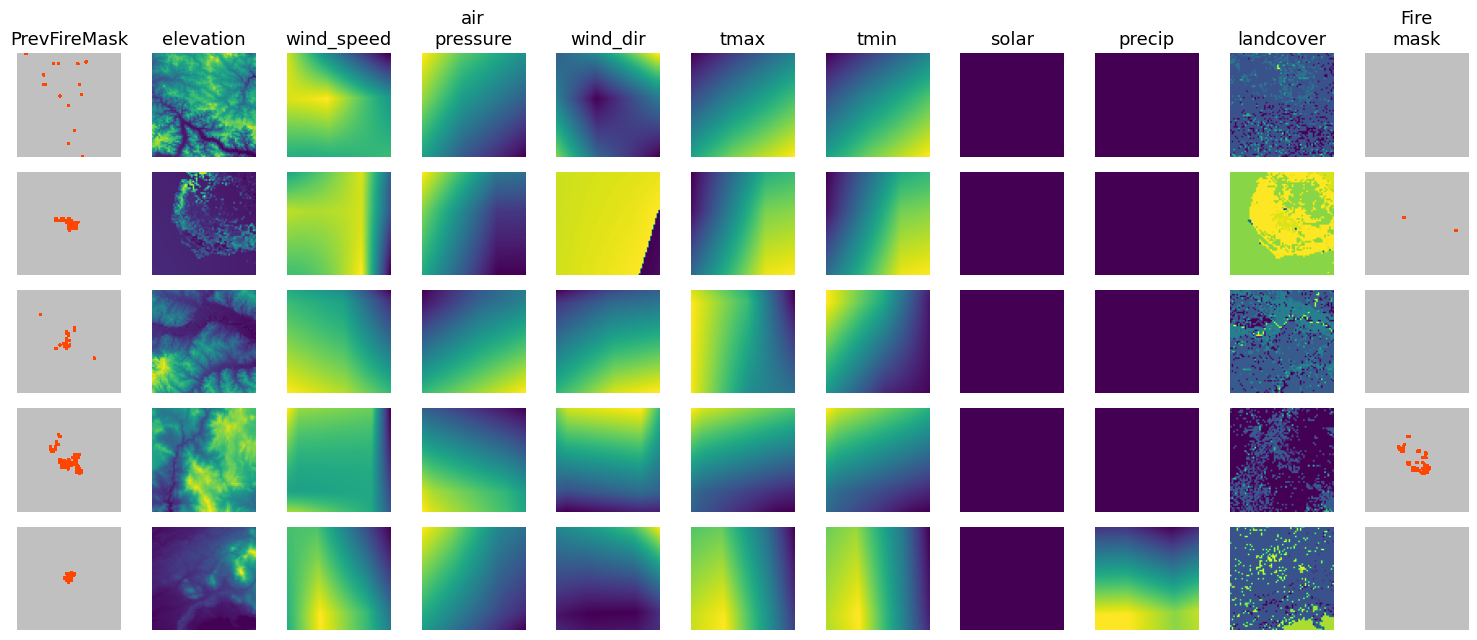

In [19]:
inputs, labels = next(iter(train_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# #all_prev_fire, all_next_fire = tf.zeros([1, 64, 64]), tf.zeros([1, 64, 64])
# #first = True
# ssim_scores, fid_scores = [], []
# for inputs, labels in tqdm(train_dataset):
#     ssim_score = float(tf.reduce_mean(get_ssim_score(inputs[:, :, :, 0], labels[:, :, :])))
#     #fid_score = get_fid_score(inputs[:, :, :, 0], labels[:, :, :])
#     ssim_scores.append(ssim_score)
#     #fid_scores.append(fid_score)
#     # if first:
#     #     all_prev_fire = inputs[:, :, :, 0]
#     #     all_next_fire = labels[:, :, :]
#     #     first = False
#     # else:
#     #     all_prev_fire = tf.concat((all_prev_fire, inputs[:, :, :, 0]), axis=0)
#     #     all_next_fire = tf.concat((all_next_fire, labels[:, :, :]), axis=0)

# #ssim_score = get_ssim_score(all_prev_fire, all_next_fire)
# #fid_score = get_fid_score(all_prev_fire, all_next_fire)
# print(f"ssim_score: {np.mean(ssim_score)} fid_score: {np.mean(fid_scores)}")

In [21]:
# len(eval_dataset.take(1))

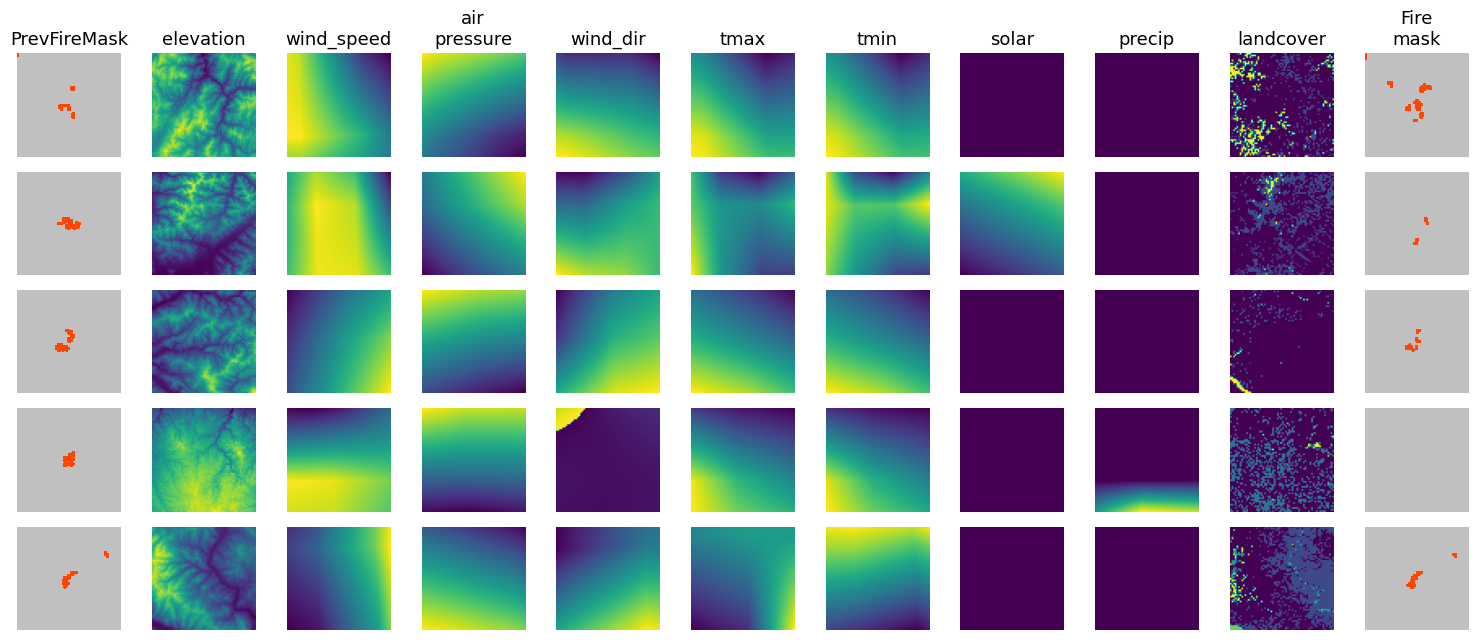

In [22]:
eval_dataset = eval_dataset.shuffle(1000)
inputs, labels = next(iter(eval_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

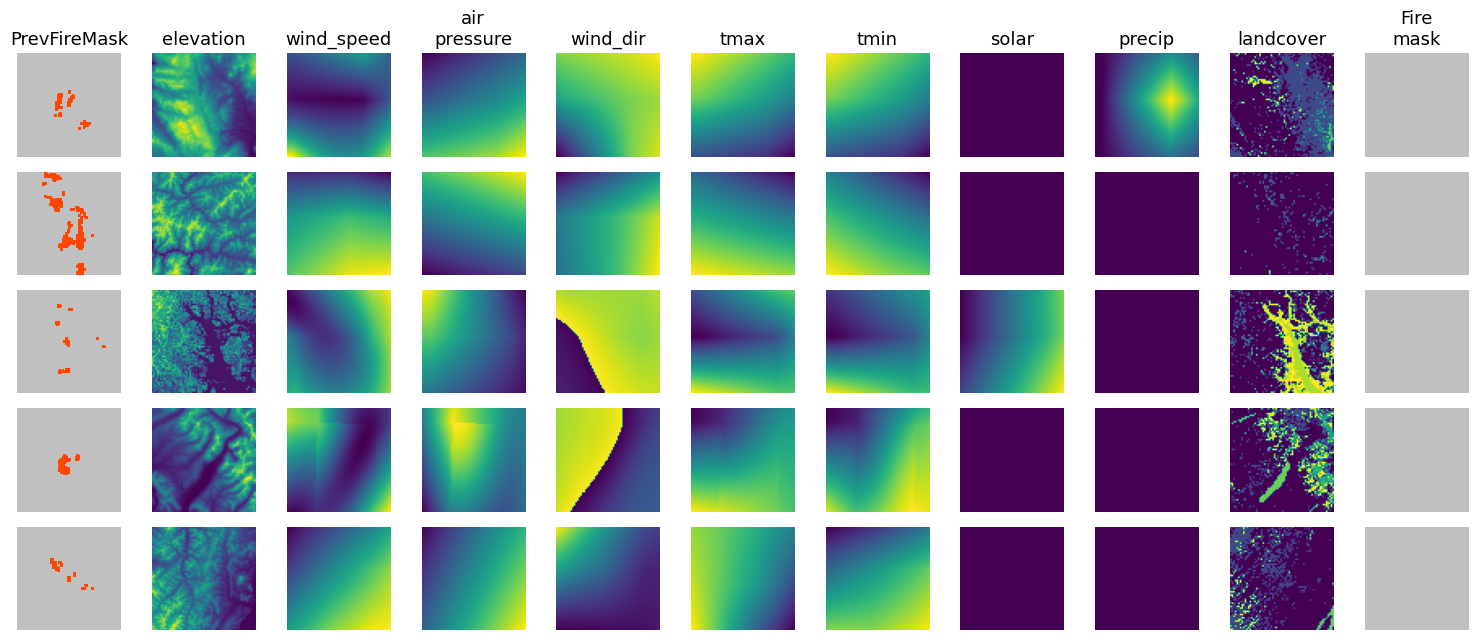

In [23]:
inputs, labels = next(iter(test_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
ssim_scores, fid_scores = [], []
for inputs, labels in tqdm(test_dataset):
    ssim_score = float(tf.reduce_mean(get_ssim_score(inputs[:, :, :, 0], labels[:, :, :])))
    #fid_score = get_fid_score(inputs[:, :, :, 0], labels[:, :, :])
    ssim_scores.append(ssim_score)
    #fid_scores.append(fid_score)

print(f"ssim_score: {np.mean(ssim_score)} fid_score: {np.mean(fid_scores)}")

0it [00:00, ?it/s]

ssim_score: 0.8661971688270569 fid_score: nan


/home/adsadmin/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/adsadmin/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
# Evaluate using sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Get all samples from TFRecords in arrays
first_it = True
cnt = 0
for x, y in test_dataset:
    cnt += 1
    if first_it:
        test_data_inputs = x
        test_data_targets = y
        first_it = False
    else:
        test_data_inputs = np.concatenate((test_data_inputs, x), axis=0)        
        test_data_targets = np.concatenate((test_data_targets, y), axis=0)        
print(f"test inputs num batches = {cnt}")
test_data_inputs = np.asarray(test_data_inputs)
y_true = np.asarray(test_data_targets)
print(f"test_data_targets.shape {test_data_targets.shape}")
print(f"test_data_inputs.shape {test_data_inputs.shape}")

# Flatten results before evaluation
previous_fire_mask_flat = test_data_inputs[:, :, :, 0].flatten()
persistence_mask_flat = previous_fire_mask_flat
y_true_flat = y_true.flatten()

test inputs num batches = 68
test_data_targets.shape (2155, 64, 64)
test_data_inputs.shape (2155, 64, 64, 10)


In [26]:
# # Metrics for baseline
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, persistence_mask_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, persistence_mask_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, persistence_mask_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, persistence_mask_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, persistence_mask_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, persistence_mask_flat)
print(matrix)

Accuracy: 0.983728
score_a (array([0.99638024, 0.15630124]), array([0.98721735, 0.39769182]), array([0.99177763, 0.22440615]), array([8774631,   52249]))
precision 0.9837277724405452
Recall: 0.983728
F1 score: 0.983728
[[8662468  112163]
 [  31470   20779]]


# Training

In [27]:
# Compile and train model
model.compile(
    optimizer=optimizer,
    loss=loss_function, metrics=[dice_coef,
                                 tf.keras.metrics.AUC(curve="PR"),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()
                                ]
    )

#model.fit(train_dataset, epochs=5)
history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=100,
    #callbacks=callbacks
)

Epoch 1/100


2023-12-07 16:37:37.012219: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-07 16:37:37.129850: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-07 16:37:39.033472: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f501e3584a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 16:37:39.033499: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-07 16:37:39.038896: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701995859.136470 3022541 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


539/539 [==============================] - 56s 62ms/step - loss: 0.8058 - dice_coef: 0.1943 - auc: 0.0614 - precision: 0.0551 - recall: 0.4520 - val_loss: 0.7580 - val_dice_coef: 0.2447 - val_auc: 0.1149 - val_precision: 0.1858 - val_recall: 0.3947
Epoch 2/100
539/539 [==============================] - 28s 46ms/step - loss: 0.7596 - dice_coef: 0.2404 - auc: 0.1088 - precision: 0.1879 - recall: 0.3682 - val_loss: 0.7714 - val_dice_coef: 0.2294 - val_auc: 0.0964 - val_precision: 0.2083 - val_recall: 0.2657
Epoch 3/100
539/539 [==============================] - 30s 43ms/step - loss: 0.7492 - dice_coef: 0.2508 - auc: 0.1147 - precision: 0.2005 - recall: 0.3666 - val_loss: 0.7508 - val_dice_coef: 0.2500 - val_auc: 0.1169 - val_precision: 0.2202 - val_recall: 0.3257
Epoch 4/100
539/539 [==============================] - 35s 56ms/step - loss: 0.7506 - dice_coef: 0.2494 - auc: 0.1141 - precision: 0.2037 - recall: 0.3545 - val_loss: 0.7664 - val_dice_coef: 0.2331 - val_auc: 0.1023 - val_precisi

# Evaluation

In [28]:
# Predict
y_pred=list()
for sample in tqdm(test_data_inputs):
    sample_exp = np.expand_dims(sample, axis=0)
    
    pred = model.predict(sample_exp, verbose = 0)
    
    y_pred.append(pred)
    
masks = np.round(y_pred)

# Flatten results before evaluation
y_pred_mask_flat = np.expand_dims(np.array(y_pred).squeeze(), axis=-1).flatten()
masks_flat = masks.flatten()

# Metrics for predicitions
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, masks_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, masks_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, masks_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, masks_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, masks_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, masks_flat)
print(matrix)

  0%|          | 0/2155 [00:00<?, ?it/s]

Accuracy: 0.990332
score_a (array([0.99577207, 0.23939136]), array([0.99449686, 0.29087638]), array([0.99513406, 0.26263447]), array([8774631,   52249]))
precision 0.9903319179596868
Recall: 0.990332
F1 score: 0.990332
[[8726343   48288]
 [  37051   15198]]


In [29]:
ssim_scores_input_labels = []
ssim_scores_input_predictions = []
ssim_scores_labels_predictions = []
for inputs, labels in tqdm(test_dataset):
    pred = tf.squeeze(model.predict(inputs, verbose = 0))
    ssim_score = float(tf.reduce_mean(get_ssim_score(inputs[:, :, :, 0], labels[:, :, :])))
    ssim_scores_input_labels.append(ssim_score)
    ssim_score = float(tf.reduce_mean(get_ssim_score(inputs[:, :, :, 0], pred)))
    ssim_scores_input_predictions.append(ssim_score)
    ssim_score = float(tf.reduce_mean(get_ssim_score(labels[:, :, :], pred)))
    ssim_scores_labels_predictions.append(ssim_score)
    

print(f"final_ssim_scores_input_labels.append({np.mean(ssim_scores_input_labels)})")
print(f"final_ssim_scores_input_predictions.append({np.mean(ssim_scores_input_predictions)})")
print(f"final_ssim_scores_labels_predictions.append({np.mean(ssim_scores_labels_predictions)})")

0it [00:00, ?it/s]

final_ssim_scores_input_labels.append(0.8387461637749392)
final_ssim_scores_input_predictions.append(0.8933107178000843)
final_ssim_scores_labels_predictions.append(0.8956582949442022)


In [30]:
np.where(y_true_flat < 1.)

(array([      0,       1,       2, ..., 8826877, 8826878, 8826879]),)

In [31]:
y_true.shape

(2155, 64, 64)

In [32]:
tf.unique(persistence_mask_flat)

Unique(y=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>, idx=<tf.Tensor: shape=(8826880,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

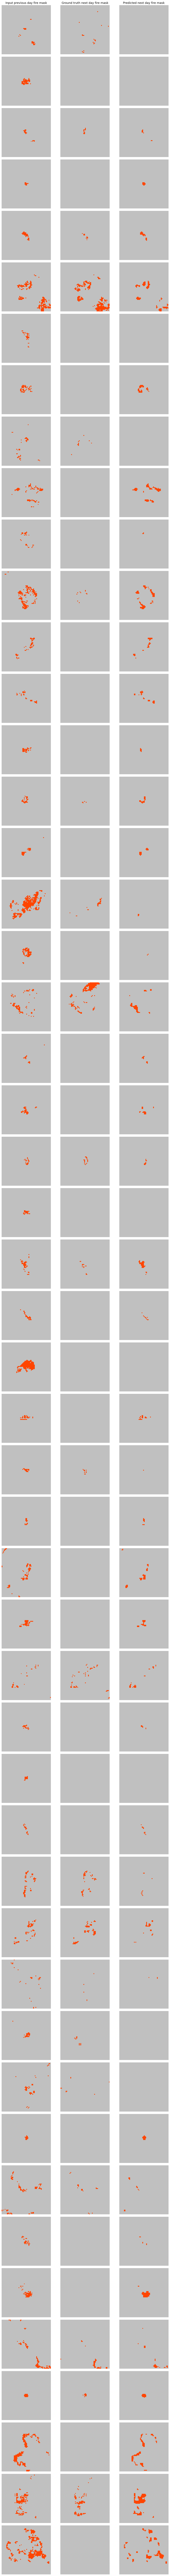

In [33]:
# Output visualisation
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 50
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,160.5))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=13)
        if j == 0:
            plt.imshow(test_data_inputs[i, :, :, 0], cmap=CMAP, norm=NORM) 
        if j == 1:
            plt.imshow(y_true[i, :, :], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks.squeeze(axis=1)[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()

In [4]:
final_ssim_scores_input_labels = []
final_ssim_scores_input_predictions = []
final_ssim_scores_labels_predictions = []

In [5]:
final_ssim_scores_input_labels.append(0.8382500436376122)
final_ssim_scores_input_predictions.append(0.9050391088513767)
final_ssim_scores_labels_predictions.append(0.8892595934517243)

final_ssim_scores_input_labels.append(0.8439870573141995)
final_ssim_scores_input_predictions.append(0.9124983961091322)
final_ssim_scores_labels_predictions.append(0.886075835017597)

final_ssim_scores_input_labels.append(0.8387461637749392)
final_ssim_scores_input_predictions.append(0.8933107178000843)
final_ssim_scores_labels_predictions.append(0.8956582949442022)

In [7]:
import numpy as np
print(f"final_ssim_scores_input_labels: {np.mean(final_ssim_scores_input_labels):.5f} +- {np.std(final_ssim_scores_input_labels):.5f}")
print(f"final_ssim_scores_input_predictions: {np.mean(final_ssim_scores_input_predictions):.5f} +- {np.std(final_ssim_scores_input_predictions):.5f}")
print(f"final_ssim_scores_labels_predictions: {np.mean(final_ssim_scores_labels_predictions):.5f} +- {np.std(final_ssim_scores_labels_predictions):.5f}")

final_ssim_scores_input_labels: 0.84033 +- 0.00260
final_ssim_scores_input_predictions: 0.90362 +- 0.00790
final_ssim_scores_labels_predictions: 0.89033 +- 0.00398


In [9]:
from sklearn.metrics import f1_score
f1_score([1,0,1], [1,0,1], average='micro')

1.0

In [36]:
# f1 score

satunet_mean = np.mean([0.990430, 0.988026, 0.986947])
satunet_std = np.std([0.990430, 0.988026, 0.986947])

print(f"f1 baseline: satunet: {satunet_mean:.5f}+={satunet_std:.5f}")


# precision

satunet_mean = np.mean([0.9904296875, 0.9880262335049304, 0.9869474831424014])
satunet_std = np.std([0.9904296875, 0.9880262335049304, 0.9869474831424014])

print(f"precision satunet: {satunet_mean:.5f}+={satunet_std:.5f}")


# recall

satunet_mean = np.mean([0.990430, 0.988026, 0.986947])
satunet_std = np.std([0.990430, 0.988026, 0.986947])

print(f"recall satunet: {satunet_mean:.5f}+={satunet_std:.5f}")


# accuracy

satunet_mean = np.mean([0.990430,  0.988026, 0.986947])
satunet_std = np.std([0.990430,  0.988026, 0.986947])

print(f"accuracy satunet: {satunet_mean:.5f}+={satunet_std:.5f}")

f1 baseline: satunet: 0.98847+=0.00146
precision satunet: 0.98847+=0.00146
recall satunet: 0.98847+=0.00146
accuracy satunet: 0.98847+=0.00146


In [37]:
import re
import numpy as np

# Input data
data = """
Accuracy: 0.990430
score_a (array([0.99469744, 0.24384605]), array([0.9956733 , 0.20815681]), array([0.99518513, 0.22459245]), array([8768107,   58773]))
precision 0.9904296875
Recall: 0.990430
F1 score: 0.990430
[[8730170   37937]
 [  46539   12234]]

Accuracy: 0.988026
score_a (array([0.99617688, 0.18523862]), array([0.99176442, 0.32972854]), array([0.99396576, 0.23721303]), array([8777039,   49841]))
precision 0.9880262335049304
Recall: 0.988026
F1 score: 0.988026
[[8704755   72284]
 [  33407   16434]]

Accuracy: 0.986947
score_a (array([0.99611334, 0.19403192]), array([0.99073357, 0.36592069]), array([0.99341618, 0.25359394]), array([8773393,   53487]))
precision 0.9869474831424014
Recall: 0.986947
F1 score: 0.986947
[[8692095   81298]
 [  33915   19572]]
"""

# Extracting values using regular expressions
accuracy_values = [float(match.group(1)) for match in re.finditer(r"Accuracy: (\d+\.\d+)", data)]
precision_values = [float(match.group(1)) for match in re.finditer(r"precision (\d+\.\d+)", data)]
recall_values = [float(match.group(1)) for match in re.finditer(r"Recall: (\d+\.\d+)", data)]
f1_score_values = [float(match.group(1)) for match in re.finditer(r"F1 score: (\d+\.\d+)", data)]

# Calculating mean and standard deviation
mean_accuracy = np.mean(accuracy_values)
std_accuracy = np.std(accuracy_values)

mean_precision = np.mean(precision_values)
std_precision = np.std(precision_values)

mean_recall = np.mean(recall_values)
std_recall = np.std(recall_values)

mean_f1_score = np.mean(f1_score_values)
std_f1_score = np.std(f1_score_values)

# Displaying results
format_string = "{:.5f}+={:.5f}"
print(f"Accuracy: {format_string.format(mean_accuracy, std_accuracy)}")
print(f"Precison: {format_string.format(mean_precision, std_precision)}")
print(f"Recall: {format_string.format(mean_recall, std_recall)}")
print(f"F1 Score: {format_string.format(mean_f1_score, std_f1_score)}")

Accuracy: 0.98847+=0.00146
Precison: 0.98847+=0.00146
Recall: 0.98847+=0.00146
F1 Score: 0.98847+=0.00146
